In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

Import OSNIR Dataset and shuffle data

In [38]:
# import OSNIR dataset
df = pd.read_csv('../Data/OSNIR_values_extendedv3_new datasetbcsv.csv')
# shuffling rows of OSNIR dataframe and reset indexes
df = df.sample(frac=1)
df.reset_index(inplace=True, drop=True)

Preview of first 5 samples

In [39]:
df.head()

,OSNIRnumerical(dB),Ns,Pch(dBm),L(km),B(GHz),GB(GHz),Nch
0,10.655224,38,-3,100,12.5,0.0,9
1,14.920383,50,-7,50,25.0,0.0,3
2,18.138504,30,-2,50,25.0,0.0,3
3,9.459131,36,1,100,25.0,0.0,9
4,25.856131,19,-8,10,25.0,0.0,9


1800 values for training (0,1800-1)\
600 values for validation (1800,2400-1)\
600 values for testing (2400,3000-1)

In [40]:
data = np.array(df)

In [41]:
# input x aka Ns, Pch, L, B, GB, Nch values
x_train = data[0:1800-1, 1:7]
x_valid = data[1800:2400-1, 1:7]
x_test = data[2400:3000-1, 1:7]

# output y aka OSNIR values
y_train = data[0:1800-1, 0]
y_valid = data[1800:2400-1, 0]
y_test = data[2400:3000-1, 0]

In [42]:
x_train

array([[ 38. ,  -3. , 100. ,  12.5,   0. ,   9. ],
       [ 50. ,  -7. ,  50. ,  25. ,   0. ,   3. ],
       [ 30. ,  -2. ,  50. ,  25. ,   0. ,   3. ],
       ...,
       [ 48. ,   0. , 100. ,  12.5,   0. ,   9. ],
       [ 41. ,   3. ,  50. ,  25. ,  25. ,   9. ],
       [ 22. ,  -3. ,  50. ,  12.5,   0. ,   9. ]])

### Create the Neural Network
1 Input layer, 2 hidden layers (32 neurons each) and 1 Output Layer

In [43]:
model = keras.Sequential([
    keras.layers.Dense(32, input_shape=(6,), activation='relu'),  # first hidden layer
    keras.layers.Dense(32, activation='relu'),  # second hidden layer
    keras.layers.Dense(1, activation='relu') # output layer (3)
])

Early hault of training if loss has not improved in 50 epochs in validation set

In [44]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=50)

Adam Optimizer, Mean Square Error Loss

In [45]:
model.compile(optimizer='adam',
              loss='mse'
              )

Fitting the model, run for 500 epochs

In [46]:
model.fit(x_train, y_train,
          validation_data=(x_valid,y_valid), 
          epochs=500, 
          batch_size=25,
          callbacks=[early_stop])

Epoch 1/500
72/72 [==============================] - 1s 3ms/step - loss: 105.8782 - val_loss: 54.2099
Epoch 2/500
72/72 [==============================] - 0s 2ms/step - loss: 46.0105 - val_loss: 38.0755
Epoch 3/500
72/72 [==============================] - 0s 2ms/step - loss: 35.1541 - val_loss: 32.8401
Epoch 4/500
72/72 [==============================] - 0s 2ms/step - loss: 29.8212 - val_loss: 29.3665
Epoch 5/500
72/72 [==============================] - 0s 2ms/step - loss: 27.1150 - val_loss: 28.1113
Epoch 6/500
72/72 [==============================] - 0s 2ms/step - loss: 25.2967 - val_loss: 26.8154
Epoch 7/500
72/72 [==============================] - 0s 2ms/step - loss: 23.1451 - val_loss: 25.6526
Epoch 8/500
72/72 [==============================] - 0s 2ms/step - loss: 21.4167 - val_loss: 23.4821
Epoch 9/500
72/72 [==============================] - 0s 2ms/step - loss: 20.1709 - val_loss: 23.1239
Epoch 10/500
72/72 [==============================] - 0s 2ms/step - loss: 18.5513 - val_lo

In [47]:
OSNIR_num = data[:3000-1,0]
Input_num = data[:3000-1,1:7]

In [48]:
OSNIR_est = (model.predict(Input_num)) 

94/94 [==============================] - 0s 2ms/step


In [49]:
for i in range(10):
    print('%s => %f (expected %f)' % (Input_num[i].tolist(), OSNIR_est[i], OSNIR_num[i] ))

[38.0, -3.0, 100.0, 12.5, 0.0, 9.0] => 11.174129 (expected 10.655224)
[50.0, -7.0, 50.0, 25.0, 0.0, 3.0] => 15.434303 (expected 14.920383)
[30.0, -2.0, 50.0, 25.0, 0.0, 3.0] => 18.075792 (expected 18.138504)
[36.0, 1.0, 100.0, 25.0, 0.0, 9.0] => 9.255724 (expected 9.459131)
[19.0, -8.0, 10.0, 25.0, 0.0, 9.0] => 25.379766 (expected 25.856131)
[24.0, -4.0, 100.0, 12.5, 0.0, 9.0] => 12.648388 (expected 12.804099)
[25.0, -7.0, 100.0, 25.0, 0.0, 9.0] => 7.791731 (expected 7.938533)
[29.0, 3.0, 100.0, 25.0, 25.0, 9.0] => 9.921718 (expected 9.551508)
[27.0, 3.0, 10.0, 50.0, 0.0, 9.0] => 17.149124 (expected 17.620399)
[13.0, 3.0, 100.0, 25.0, 12.5, 9.0] => 13.806187 (expected 13.479461)


Calculate difference between actual OSNIR and predicted OSNIR (in dB)

In [50]:
Mism = np.zeros(3000-1)
for i in range(3000-1):
    Mism[i] = OSNIR_num[i] - OSNIR_est[i]

In [51]:
pred_df = pd.DataFrame({"Actual OSNIR (dB)" : OSNIR_num.tolist(), "Predicted OSNIR (dB)" : OSNIR_est.tolist(), "Difference (dB)" : Mism.tolist()})
pred_df.to_csv("OSNIR_Prediction.csv",index=False)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   2.,  16., 112., 283., 576.,
        825., 681., 337., 122.,  27.,   9.,   4.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([-4.        , -3.82222222, -3.64444444, -3.46666667, -3.28888889,
        -3.11111111, -2.93333333, -2.75555556, -2.57777778, -2.4       ,
        -2.22222222, -2.04444444, -1.86666667, -1.68888889, -1.51111111,
        -1.33333333, -1.15555556, -0.97777778, -0.8       , -0.62222222,
        -0.44444444, -0.26666667, -0.08888889,  0.08888889,  0.26666667,
         0.44444444,  0.62222222,  0.8       ,  0.97777778,  1.15555556,
         1.33333333,  1.51111111,  1.68888889,  1.86666667,  2.04444444,
         2.22222222,  2.4       ,  2.57777778,  2.75555556,  2.93333333,
         3.11111111,  3.28888889,  3.46666667,  3.64444444,  3.82222222,
         4.        ]),
 <BarCon

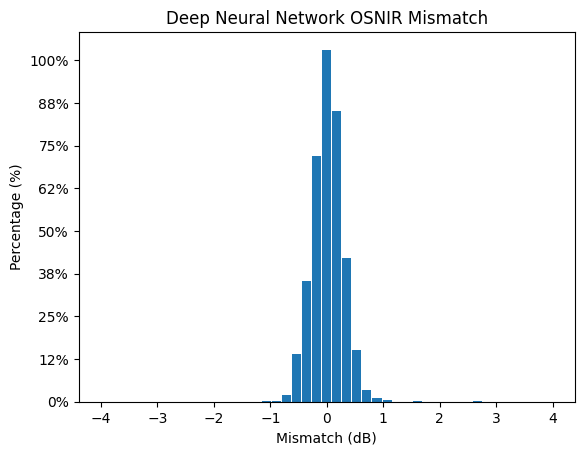

In [57]:
plt.title('Deep Neural Network OSNIR Mismatch')
plt.xlabel('Mismatch (dB)')
plt.ylabel('Percentage (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(800))
plt.hist(Mism, range=(-4,4), rwidth=0.9, bins=45)